In [1]:
import pandas as pd

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import FirefoxOptions

def get_country(country, driver=None):
    print(country)
    _driver = driver
    if driver is None:
        _driver = webdriver.Firefox()
    url = f"https://www.worldometers.info/coronavirus/country/{country}/"
    _driver.get(url)
    html = _driver.find_element_by_tag_name("html").get_attribute("innerHTML")
    if driver is None:
        _driver.close()
    return html

In [3]:
opts = FirefoxOptions()
opts.headless = True
driver = webdriver.Firefox(options=opts)
print("entering")
raw_charts = {country: get_country(country, driver=driver)
              for country in ["italy", "us", "south-korea", "germany", "uk", "china"]}
driver.close()


entering
italy
us
south-korea
germany
uk
china


In [4]:
import json
import ast

def process_chart(html, var="cases"):
    i = html.find(f"Highcharts.chart('coronavirus-{var}-linear")
    h = html[i:]
    j = h.find("</script>")
    start = h.find("{")

    chart = h[start:j]

    start = chart.find("categories")
    h = chart[start:]
    end = h.find("]")
    start = h.find(":")
    xdata = h[start + 2:end + 1]
    xdata = ast.literal_eval(xdata)

    ydata = chart.find("yAxis")
    ydata = chart[ydata:]
    i = ydata.find("data")
    ydata = ydata[i:]
    j = ydata.find("]")
    i = ydata.find(": ")
    ydata = ydata[i + 2:j + 1]
    ydata = ast.literal_eval(ydata)
    return {"date": xdata, "cases": ydata}

In [5]:
charts = [
    {"data": process_chart(html, var=v), "country": c, "var": v}
    for c, html in raw_charts.items()
    for v in ["cases", "deaths"]
]

dfs = []
for d in charts:
    if d["country"] in ["china", "germany"]:
        continue
    df = pd.DataFrame(d["data"])
    df["country"] = d["country"]
    df["var"] = d["var"]
    dfs.append(df)
    
df = pd.concat(dfs)
df.sample(n=3)

,date,cases,country,var
6,Feb 21,21,italy,cases
14,Feb 29,17,south-korea,deaths
28,Mar 14,57,us,deaths


In [6]:
import numpy as np
from datetime import datetime

df["year"] = 2020
months = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4}
df["month"] = df["date"].apply(lambda x: months[x.split(" ")[0]])
df["day"] = df["date"].apply(lambda x: int(x.split(" ")[1]))

df["_days"] = np.arange(len(df))
df["datetime"] = df.apply(lambda row: datetime(row.year, row.month, row.day), axis=1)

In [7]:
d = df.sort_values(by="datetime")
d[d.country == "us"].tail()

,date,cases,country,var,year,month,day,_days,datetime
48,Apr 03,277161,us,cases,2020,4,3,150,2020-04-03
49,Apr 04,311357,us,cases,2020,4,4,151,2020-04-04
49,Apr 04,8451,us,deaths,2020,4,4,202,2020-04-04
50,Apr 05,9616,us,deaths,2020,4,5,203,2020-04-05
50,Apr 05,336673,us,cases,2020,4,5,152,2020-04-05


In [8]:
meta = {
    "south-korea": {"population": 51709098, "beds_per_1000": 12.27},
    "germany": {"population": 83149300, "beds_per_1000": 8.00},
    "uk": {"population": 67545757, "beds_per_1000": 2.54, "p65+": 0.18, "ccb": 6.6},
    "italy": {"population": 60317546, "beds_per_1000": 3.18, "p65+": 0.2169, "ccb": 12.5},
    "us": {"population": 328239523, "beds_per_1000": 2.77, "p65+": 0.16, "ccb": 34.7},
}

In [9]:
to_show = ["uk", "us", "italy", "south-korea"]

for k, c in enumerate(to_show):
    meta[c]["color"] = f"C{k}"

In [10]:
import numpy as np
df["concentration"] = np.nan
for country in to_show:
    idx = df.country == country
    df.loc[idx, "concentration"] = df.loc[idx, "cases"] / meta[country]["population"]

In [11]:
df.head()

,date,cases,country,var,year,month,day,_days,datetime,concentration
0,Feb 15,3,italy,cases,2020,2,15,0,2020-02-15,4.973677e-08
1,Feb 16,3,italy,cases,2020,2,16,1,2020-02-16,4.973677e-08
2,Feb 17,3,italy,cases,2020,2,17,2,2020-02-17,4.973677e-08
3,Feb 18,3,italy,cases,2020,2,18,3,2020-02-18,4.973677e-08
4,Feb 19,3,italy,cases,2020,2,19,4,2020-02-19,4.973677e-08


In [12]:
idx = (df.datetime == datetime(2020, 3, 12)) & (df.country == "italy") & (df["var"] == "cases")
row = df.loc[idx]
print(row)
meta["italy"]["hc_limit"] = row.cases.item()
meta["italy"]

      date  cases country    var  year  month  day  _days   datetime  \
26  Mar 12  15113   italy  cases  2020      3   12     26 2020-03-12   

    concentration  
26       0.000251  


{'population': 60317546,
 'beds_per_1000': 3.18,
 'p65+': 0.2169,
 'ccb': 12.5,
 'color': 'C2',
 'hc_limit': 15113}

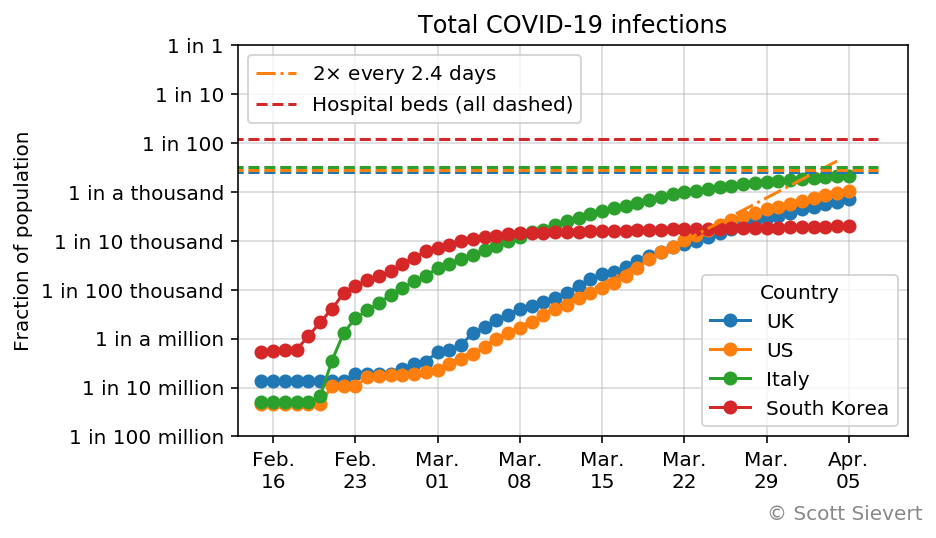

In [13]:
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def to_text(num, _):
    pwr = np.log10(num)
    rate = int(1 / num)
    if (rate + 1) % 10 == 0:
        rate += 1
    fmt = str(rate)
    if rate / 1000 > 1:
        fmt = f"{rate // 1000} thousand"
    if rate / 1000 == 1:
        fmt = f"a thousand"
    if rate / 1e6 > 1:
        fmt = f"{int(rate // 1e6)} million"
    if rate / 1e6 == 1:
        fmt = "a million"
    return "1 in {}".format(fmt)

w = 3
fig, ax = plt.subplots(figsize=(2 * w, 1.2 * w))

### Breakdowns/starts regions


### Infection concentrations
lines = []
for c in to_show:
    s = df[(df.country == c) & (df["var"] == "cases")]
    l = c.upper() if len(c) == 2 else c.capitalize()
    if c == "south-korea":
        l = "South Korea"
    line, = ax.plot(s.datetime, s.concentration, "o-{}".format(meta[c]["color"]), label=l)
    lines.append(line)
country_legend = ax.legend(handles=lines, loc="lower right", title="Country")
ax.add_artist(country_legend)

### Dotted/dashed lines
lines = []
# US predicted infections
days = df.datetime - df.datetime.min()
days = days.apply(lambda x: x.total_seconds() / (60 * 60 * 24))
days = np.arange(0, 50)

rate = 2.4
us_infections = 2 ** ((days - 0) / rate)
us_infections[us_infections < 50] = np.nan
us_conc = us_infections / meta["us"]["population"]

mdays = [mdates.date2num(datetime(2020, 2, 15) + timedelta(days=int(d))) for d in days]
line, = ax.plot(mdays, us_conc, "{}-.".format(meta["us"]["color"]), label=f"2$\\times$ every {rate} days")
lines.append(line)

ax.set_xlabel("")
ax.set_title("Total COVID-19 infections")
# Italian health collapse: https://www.reuters.com/article/us-health-coronavirus-italy-idUSKBN20X11D
# N hospital beds
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for k, c in enumerate(to_show):
    beds = meta[c]["beds_per_1000"] / 1000
    line, = ax.plot(xlim, [beds, beds], f"C{k}--", label=f"Hospital beds (all dashed)")
    if c == "south-korea":
        lines.append(line)
ax.legend(handles=lines, loc="upper left")
ax.text(mdates.date2num(datetime(2020, 3, 29)), 0.2e-9, "© Scott Sievert", color="#" + "8" * 6)

### Styling
ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_ylabel("Fraction of population")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b.\n%d'))

# Setting y ticks to be weeks
weeks = pd.date_range(start=df.datetime.min(), end=df.datetime.min() + timedelta(days=1200), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.yaxis.set_major_locator(plt.LogLocator(numticks=20))
ax.yaxis.set_major_formatter(plt.FuncFormatter(to_text))

ax.set_ylim(1e-8, 1)
x = [mdates.date2num(_) for _ in [datetime(2020, 2, 13), datetime(2020, 4, 10)]]
ax.set_xlim(*x)
# cax.set_xlim(*x)

fig.savefig("imgs/coronavirus.svg", bbox_inches="tight")
fig.savefig("imgs/coronavirus.png", bbox_inches="tight", dpi=300)

In [14]:
df[df.datetime == datetime(2020, 3, 20)]

,date,cases,country,var,year,month,day,_days,datetime,concentration
34,Mar 20,47021,italy,cases,2020,3,20,34,2020-03-20,7.795576e-04
34,Mar 20,4032,italy,deaths,2020,3,20,85,2020-03-20,6.684622e-05
34,Mar 20,19367,us,cases,2020,3,20,136,2020-03-20,5.900264e-05
34,Mar 20,255,us,deaths,2020,3,20,187,2020-03-20,7.768717e-07
34,Mar 20,8652,south-korea,cases,2020,3,20,238,2020-03-20,1.673207e-04
34,Mar 20,94,south-korea,deaths,2020,3,20,289,2020-03-20,1.817862e-06
34,Mar 20,3983,uk,cases,2020,3,20,340,2020-03-20,5.896743e-05
34,Mar 20,177,uk,deaths,2020,3,20,391,2020-03-20,2.620446e-06


In [15]:
df[df.datetime == datetime(2020, 3, 12)]

,date,cases,country,var,year,month,day,_days,datetime,concentration
26,Mar 12,15113,italy,cases,2020,3,12,26,2020-03-12,2.505573e-04
26,Mar 12,1016,italy,deaths,2020,3,12,77,2020-03-12,1.684419e-05
26,Mar 12,1630,us,cases,2020,3,12,128,2020-03-12,4.965886e-06
26,Mar 12,41,us,deaths,2020,3,12,179,2020-03-12,1.249088e-07
26,Mar 12,7869,south-korea,cases,2020,3,12,230,2020-03-12,1.521782e-04
26,Mar 12,66,south-korea,deaths,2020,3,12,281,2020-03-12,1.276371e-06
26,Mar 12,590,uk,cases,2020,3,12,332,2020-03-12,8.734820e-06
26,Mar 12,10,uk,deaths,2020,3,12,383,2020-03-12,1.480478e-07


In [16]:
df.to_csv("data/worldometers.csv", index=False)

In [17]:
to_show

['uk', 'us', 'italy', 'south-korea']

In [18]:
meta

{'south-korea': {'population': 51709098,
  'beds_per_1000': 12.27,
  'color': 'C3'},
 'germany': {'population': 83149300, 'beds_per_1000': 8.0},
 'uk': {'population': 67545757,
  'beds_per_1000': 2.54,
  'p65+': 0.18,
  'ccb': 6.6,
  'color': 'C0'},
 'italy': {'population': 60317546,
  'beds_per_1000': 3.18,
  'p65+': 0.2169,
  'ccb': 12.5,
  'color': 'C2',
  'hc_limit': 15113},
 'us': {'population': 328239523,
  'beds_per_1000': 2.77,
  'p65+': 0.16,
  'ccb': 34.7,
  'color': 'C1'}}

0.0006666666666666666 71019.12087332728


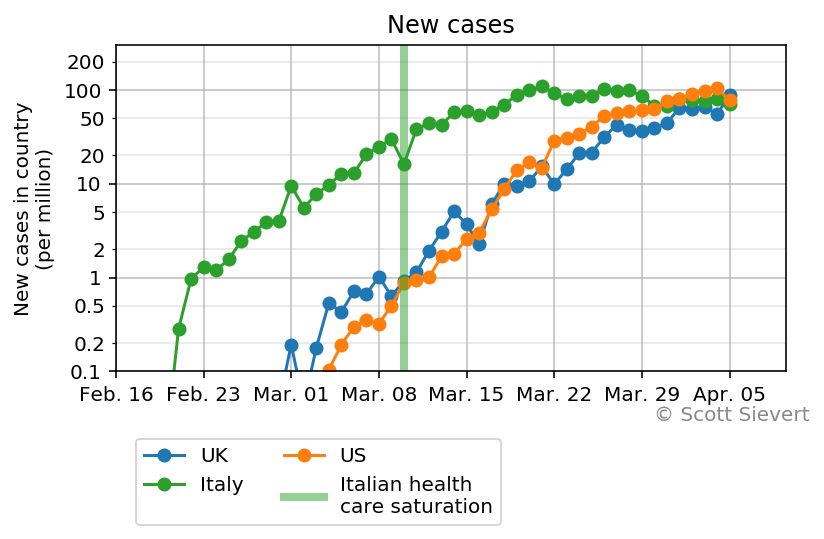

In [28]:
w = 3
fig, ax = plt.subplots(figsize=(2 * w, w))

# Italy breakdown
x = mdates.date2num(datetime(2020, 3, 10))
y = meta["italy"]["beds_per_1000"] / 1000
# ax.plot([x, x], [1e-8, 1], "{}-".format(meta["italy"]["color"]), linewidth=4, alpha=0.5, label="Italian health\ncare saturation")
# Infection concentrations
for c in reversed(to_show):
    factor = 1 / (meta[c]["population"] / 1e6)
    assert meta[c]["population"] >= 50e6
    s = df[(df.country == c) & (df["var"] == "cases")]
    l = c.upper() if len(c) == 2 else c.capitalize()
    if c == "south-korea":
        l = "South Korea"
    ax.plot(s.datetime, s.cases.diff() * factor, "o-{}".format(meta[c]["color"]), label=l, alpha=1.0)
ax.set_yscale("log")
ax.set_ylim(0.1, 300)
ax.grid(alpha=0.8)
ax.grid(alpha=0.3, which="minor", axis="y")
ax.text(mdates.date2num(datetime.now() - timedelta(days=7, hours=12)), 0.03, "© Scott Sievert", color="#" + "8" * 6)

y = meta["italy"]["beds_per_1000"] / 1000
ax.plot([x, x], ax.get_ylim(), "{}-".format(meta["italy"]["color"]), linewidth=4, alpha=0.5, label="Italian health\ncare saturation")
weeks = pd.date_range(start=datetime(2020, 2, 15), end=datetime(2020, 2, 15) + timedelta(days=60), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))
# ax.set_xlim(mdates.date2num(datetime(2020, 2, 10)), None)
ax.set_ylabel("New cases in country\n(per million)")
ax.set_xlabel("")
ax.set_title("New cases")

days = np.arange(0, 65)

rate = 2.4
us_cases = 2 ** ((days - 0) / (1 * rate))
us_cases /= 1.5e3
# us_cases[us_cases < 50] = np.nan
print(us_cases.min(), us_cases.max())

mdays = [mdates.date2num(datetime(2020, 2, 15) + timedelta(days=int(d))) for d in days]
# ax.plot(mdays, us_cases, "{}-.".format(meta["us"]["color"]), label=f"2$\\times$ every {rate} days")

yminor = sum([[2 * f, 5 * f] for f in [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]], [])
ymajor = [1 * f for f in [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]]
ax.yaxis.set_major_locator(plt.FixedLocator(ymajor))
ax.yaxis.set_minor_locator(plt.FixedLocator(yminor))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x)) if x >= 1 else str(x)))
ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: str(int(x)) if x >= 1 else str(x)))
ax.set_xlim(datetime(2020, 2, 16), datetime.now() + timedelta(3))
ax.legend(loc=(0.03, -0.47), ncol=2)

fig.savefig("imgs/new-cases.svg", bbox_inches="tight")
fig.savefig("imgs/new-cases.png", bbox_inches="tight", dpi=300)


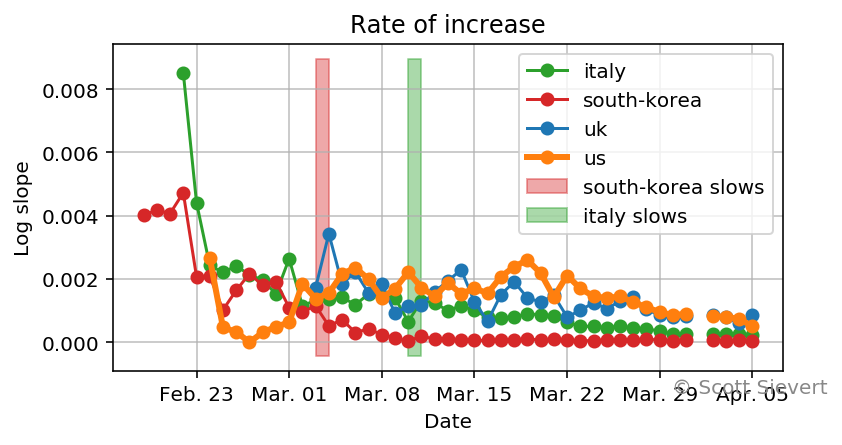

In [20]:
w = 3
fig, ax = plt.subplots(figsize=(2 * w, w))

for c in sorted(list(meta.keys())):
    if c == "germany":
        continue
    assert meta[c]["population"] >= 50e6
    s = df[(df.country == c) & (df["var"] == "cases")]
    s = s.sort_values(by="date")
    y = np.log10(s.cases).diff()
    y[s.cases < 50] = np.nan
    style = "o-{}".format(meta[c]["color"])
    kwargs = {} if c not in ["us"] else {"linewidth": 3}
    ax.plot(s.datetime, y * factor, style, label=c, **kwargs)

# ax.set_yscale("log")
ax.grid(alpha=0.8)
ax.grid(alpha=0.3, which="minor", axis="y")
ax.text(mdates.date2num(datetime.now() - timedelta(days=7, hours=12)), -1.6e-3, "© Scott Sievert", color="#" + "8" * 6)

weeks = pd.date_range(start=df.datetime.min(), end=df.datetime.min() + timedelta(days=60), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))
# ax.set_xlim(mdates.date2num(datetime(2020, 2, 10)), None)
ax.legend(loc="upper left", ncol=2)
ax.set_ylabel("Log slope")
ax.set_xlabel("Date")
ax.set_title("Rate of increase")

days = np.arange(0, 35)

rate = 2.4
# ax.set_xlim(mdates.date2num(datetime(2020, 3, 1)), None)

ylim = ax.get_ylim()
x = [mdates.date2num(_) for _ in [datetime(2020, 3, 3), datetime(2020, 3, 4)]]
kwargs = dict(y2=[ylim[1], ylim[1]], alpha=0.4, )
ax.fill_between(x, [ylim[0], ylim[0]], color=meta["south-korea"]["color"], label="south-korea slows", **kwargs)
x = [mdates.date2num(_) for _ in [datetime(2020, 3, 10), datetime(2020, 3, 11)]]
ax.fill_between(x, [ylim[0], ylim[0]], color=meta["italy"]["color"], label="italy slows", **kwargs)

ax.legend(loc="best")

In [21]:
from scipy.optimize import curve_fit

def sigmoid(x, total, offset, rate=2.4):
    return total / (1 + 2**(-(x - offset) / rate))

# for c in df.country.unique():
c = "italy"
show = df[df.country == c].copy()
days = (show.datetime - show.datetime.min()).dt.total_seconds() / (60 * 60 * 24)
popt, pcov = curve_fit(sigmoid, days, show.cases, p0=(1e4, 17))

In [22]:
meta

{'south-korea': {'population': 51709098,
  'beds_per_1000': 12.27,
  'color': 'C3'},
 'germany': {'population': 83149300, 'beds_per_1000': 8.0},
 'uk': {'population': 67545757,
  'beds_per_1000': 2.54,
  'p65+': 0.18,
  'ccb': 6.6,
  'color': 'C0'},
 'italy': {'population': 60317546,
  'beds_per_1000': 3.18,
  'p65+': 0.2169,
  'ccb': 12.5,
  'color': 'C2',
  'hc_limit': 15113},
 'us': {'population': 328239523,
  'beds_per_1000': 2.77,
  'p65+': 0.16,
  'ccb': 34.7,
  'color': 'C1'}}

In [23]:
def log_line(x, y):
    assert len(x) == len(y)
    run = x[-1] - x[0]
    mul_rate = (np.log2(y[-1]) - np.log2(y[0])) / run
    return 1 / mul_rate

Started social
isolation (all bars)


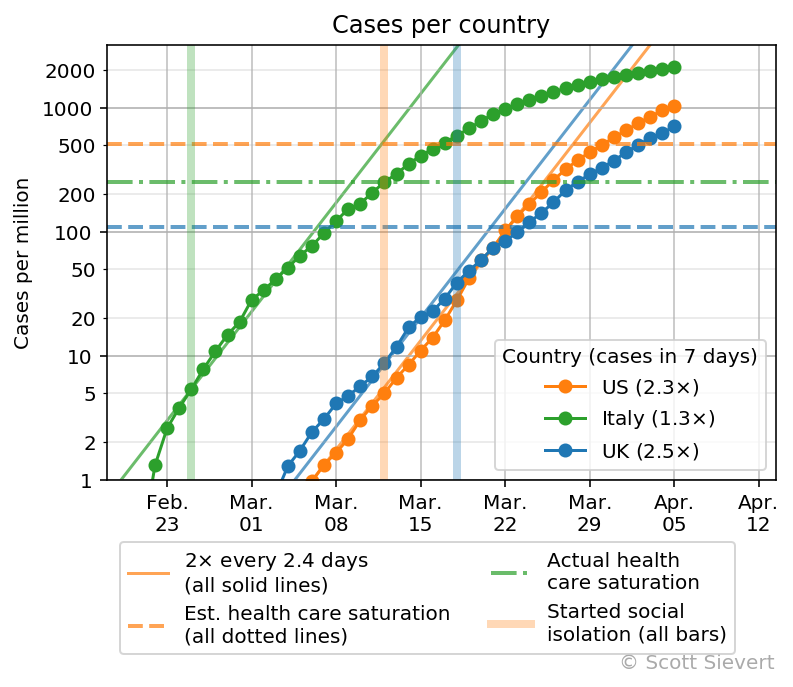

In [24]:
fig, ax = plt.subplots()
offsets = {
    "italy": timedelta(days=0),
    "south-korea": timedelta(days=0),
    "germany": timedelta(days=0),
    "us": timedelta(days=0),
    "uk": timedelta(days=10),
}
to_show = ["us", "italy", "uk"]

####################################### Number of cases
ylimmax = 0
totals = {"south-korea": 0.9e4, "italy": 4e4}
lines = []
for c in to_show:
    show = df[(df.country == c) & (df["var"] == "cases")].copy()
    show["shifted_datetime"] = show["datetime"] - offsets[c]
    style = f"{meta[c]['color']}o-"
    label = c.upper() if len(c) == 2 else c.capitalize()
    if c == "south-korea":
        label = "South Korea"
    kwargs = {"alpha": 1}
    if c == "south-korea":
        kwargs["alpha"] = 0.4
    y = show.cases / (meta[c]["population"] / 1e6)
    
    _cases_fit = show[show.datetime >= datetime.now() - timedelta(8)]
    _y = _cases_fit.cases.values
    _x = (_cases_fit.datetime - _cases_fit.datetime.min()).dt.total_seconds() / (3600 * 24)
    _x = _x.values
    _rate = log_line(_x, _y)
    _cases = 2**(7 / _rate)
    label = f"{label} ({_cases:0.1f}$\\times$)"
    
    line, = ax.plot(show.datetime, y, style, label=label, **kwargs)
    ylimmax = max(y.max(), ylimmax)
    lines.append(line)
legend1 = ax.legend(loc="best", handles=lines, title="Country (cases in 7 days)")
ax.add_artist(legend1)
x = [mdates.date2num(_) for _ in [datetime(2020, 2, 18), datetime.now() + timedelta(7)]]
ax.set_xlim(*x)

dates = {
    "Italy: started social isolation (all faded bars)": datetime(2020, 2, 25),  # school closure at https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#Management
    "Italy: health care saturation (all dark bars)": datetime(2020, 3, 11),  # https://www.nytimes.com/2020/03/12/world/europe/12italy-coronavirus-health-care.html https://www.bloomberg.com/news/articles/2020-03-10/virus-spread-pushes-italian-hospitals-toward-breaking-point
    "US: started social isolation (all bars)": datetime(2020, 3, 12),  # personal experience.
    "UK: started social isolation": datetime(2020, 3, 18),  # McD's banning customers eating in restaurant at https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom#Food_and_hospitality
    "UK: health care saturation": datetime(2020, 3, 20),  # https://www.hsj.co.uk/news/hospitals-critical-care-unit-overwhelmed-by-coronavirus-patients/7027189.article
}


xlim = ax.get_xlim()
x = np.arange(0, 50)
X = [datetime(2020, 2, 15) + timedelta(int(d)) for d in x]
rate = 2.4
kwargs = {"linewidth": 1.5, "zorder": -100, "alpha": 0.7}

lines = []
####################################### Solid lines for estimated exponential growth
y = 2**(x / rate)
line, = ax.plot(X, y / (meta["us"]["population"] / 1e6), meta["us"]["color"], label=f"2$\\times$ every {rate} days\n(all solid lines)", **kwargs)
y = 2**((x - 4) / rate)
lines.append(line)

ax.plot(X, y / (meta["uk"]["population"] / 1e6), meta["uk"]["color"], **kwargs)
y = 2**((x + 10) / rate)

ax.plot(X, y / (meta["italy"]["population"] / 1e6), meta["italy"]["color"], **kwargs)
# ax.plot(X, np.clip(2**((x + 14) / rate), 0, 1e6), meta["south-korea"]["color"], **kwargs)
ax.set_ylim(20, None)
ax.set_ylabel("Cases per million")
ax.set_xlabel("")
ax.set_title("Cases per country")
xlim = ax.get_xlim()


####################################### Dashed lines for estimated health care load
for c in ["uk", "us", "italy"]:
    pop = meta[c]["population"] / meta["italy"]["population"]
    hospitals = meta[c]["ccb"] / meta["italy"]["ccb"]
    elderly = meta[c]["p65+"] / meta["italy"]["p65+"]
    n_old = elderly * pop
    limit = hospitals * n_old * meta["italy"]["hc_limit"]
    limit = limit / (meta[c]["population"] / 1e6)
    
    kwds = {"linewidth": 2, "alpha": 0.7}
    if c == "us":
        kwds.update(label="Est. health care saturation\n(all dotted lines)")
    if c == "italy":
        kwds.update(label="Actual health\ncare saturation")
    ylimmax = max(ylimmax, limit)
    s = "-." if c == "italy" else "--"
    line, = ax.plot(xlim, [limit, limit], "{}{}".format(s, meta[c]["color"]), **kwds)
    if "label" in kwds:
        lines.append(line)
#     ax.plot(xlim, [9.5e3 * factor, 9.5e3 * factor], "--{}".format(meta["uk"]["color"]), label="Est. health care saturation\n(all dotted lines)")
#     ax.plot(xlim, [56.6e3, 56.6e3], "--{}".format(meta["us"]["color"]))
ax.set_ylim(3e-1, ylimmax * 1.5)
####################################### Solid bars for social isolation
ylim = ax.get_ylim()
for label, x in dates.items():
    if "saturation" in label:
        continue
    assert "social isolation" in label
    _x = mdates.date2num(x)
    c = label.split(":")[0].lower()
    l = " ".join(label.split(":")[1:])
    l = l.strip().capitalize()
    l = "Started social\nisolation (all bars)"
    kwds = {"label": l} if c == "us" else {}
    line, = ax.plot([x, x], ylim, "{}-".format(meta[c]["color"]), linewidth=4, alpha=0.3, **kwds)
    if kwds:
        print(l)
        lines.append(line)

ax.legend(handles=lines, loc=(0.02, -0.4), ncol=2)
ax.set_yscale("log")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b.\n%d'))
ax.grid(alpha=0.8)
ax.grid(alpha=0.3, which="minor", axis="y")
weeks = pd.date_range(start=datetime(2020, 2, 15), end=datetime(2020, 2, 15) + timedelta(days=60), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))

ymajor = [10**i for i in range(-2, 6)]
yminor = sum([[2 * f, 5 * f] for f in [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]], [])
ax.yaxis.set_major_locator(plt.FixedLocator(ymajor))
ax.yaxis.set_minor_locator(plt.FixedLocator(yminor))
ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: str(int(x))))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x))))
ax.set_ylim(1, None)
# ax.tick_params(axis="y", which="minor", grid_linestyle="--")
ax.tick_params(axis="y", which="major", grid_linewidth=1)


ax.text(ax.get_xlim()[1] - 13, 3e-2 * ax.get_ylim()[0], "© Scott Sievert", color="#" + "a" * 6)

fig.savefig("imgs/rate.svg", bbox_inches="tight")
fig.savefig("imgs/rate.png", bbox_inches="tight", dpi=300)

44    0.0
45    1.0
46    2.0
47    3.0
48    4.0
49    5.0
50    6.0
Name: datetime, dtype: float64
5.771903795970362 2.317824649917369
44    0.0
45    1.0
46    2.0
47    3.0
48    4.0
49    5.0
50    6.0
Name: datetime, dtype: float64
3.7169816960203 3.689047704591757


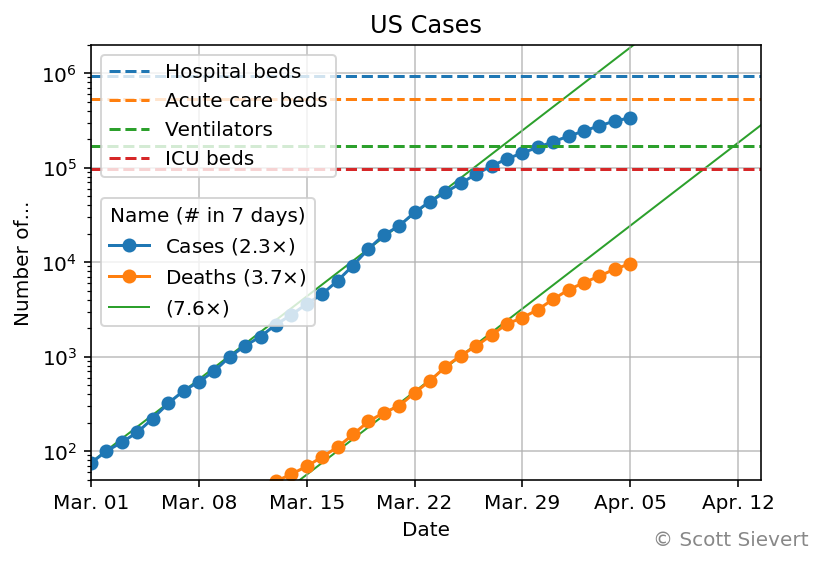

In [25]:
from datetime import timedelta
us = {
    "Hospital beds": 924100,
    "Acute care beds": 534964,
    "Ventilators": 168900,  # https://www.washingtonpost.com/health/2020/03/13/coronavirus-numbers-we-really-should-be-worried-about/
    "ICU beds": 96596,
    "hospitalization_rate": 0.1,  # https://twitter.com/LizSpecht/status/1236095180459003909
}  # https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19

totals = {"south-korea": 0.9e4, "italy": 4e4}
c = "us"

fig, ax = plt.subplots()
lines = []
for k, var in enumerate(["cases", "deaths"]):
    show = df[(df.country == c) & (df["var"] == var)].copy()
    d = 8
    _fit = show[show.datetime >= datetime.now() - timedelta(d)]
    _y = _fit.cases
    _x = (_fit.datetime - _fit.datetime.min()).dt.total_seconds() / (3600 * 24)
    print(_x)
    assert len(_x) == len(_y)
    rate = log_line(_x.values, _y.values)
    weekly_rate = 2**(7 / rate)
    print(rate, weekly_rate)
    if var == "cases":
        label = "Cases"
    elif var == "deaths":
        label = "Deaths"
    line, = ax.plot(show.datetime, show.cases, f"C{k}o-", label=f"{label} ({weekly_rate:0.1f}$\\times$)")
    lines.append(line)

ax.set_xlim(mdates.date2num(datetime(2020, 3, 1)), datetime.now() + timedelta(7))
xlim = ax.get_xlim()
x = np.arange(100)
rate = 2.4
kwargs = {"linewidth": 1, "zorder": -1}
xticks = np.array([mdates.date2num(show.datetime.min() + timedelta(int(d))) for d in x])
y = 2**(x / rate)
weekly_rate = 2**(7 / rate)
line3, = ax.plot(xticks, y, "C2", label=f"({weekly_rate:0.1f}$\\times$)", **kwargs)
lines.append(line3)
hosp  = 1.3e-2 * y
ax.plot(xticks, hosp, "C2", **kwargs)

first_legend = ax.legend(loc="center left", title="Name (# in 7 days)", handles=lines)
ax.add_artist(first_legend)

ax.set_title("US Cases")
xlim = ax.get_xlim()
meta_lines = []
for label, num in us.items():
    if "_" in label:
        continue
    line, = ax.plot(xlim, [num, num], "--", label=label)
    meta_lines.append(line)
ax.legend(loc="upper left", handles=meta_lines)

ax.set_yscale("log")
ax.grid(alpha=0.8, which="major", axis="y")
# ax.grid(alpha=0.3, which="minor", axis="y")
ax.grid(alpha=0.8, which="both", axis="x")
ax.set_ylim(50, 2e6)
ax.text(xlim[1] - 7, ax.get_ylim()[0] * 0.2, "© Scott Sievert", color="#" + "8" * 6)
ax.set_ylabel("Number of...")
ax.set_xlabel("Date")

weeks = pd.date_range(start=df.datetime.min(), end=df.datetime.min() + timedelta(days=120), freq="1W")
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %d'))

fig.savefig("imgs/us.svg", bbox_inches="tight")
fig.savefig("imgs/us.png", bbox_inches="tight", dpi=300)

Population over 65:

* S. Korea: 10.7% in 2010 ([source](https://en.wikipedia.org/wiki/Demographics_of_South_Korea#Aging_population))
* Italy: 21.69% in 2018 ([source](https://en.wikipedia.org/wiki/Demographics_of_Italy#Demographic_statistics))
* US: 16.03 in ? ([source](https://en.wikipedia.org/wiki/Demographics_of_the_United_States#Structure))
* Germany: 22.36% ([source](https://en.wikipedia.org/wiki/Demographics_of_Germany#Demographic_statistics))